# Exploratory analysis

Here we take a look at the stanford-hatespeech dataset
and try to extract and visualize its main characteristics.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import spacy
# from spacy.symbols import nsubj
# from src.data.preprocess.helpers import (
#     compare,
#     contains_bigram,
#     count_pejorative_bigrams,
#     find_most_common_nouns,
#     generate_ngrams,
#     part_of_speech_frequency,
#     verb_noun_syntactic_relation,
#     syntactic_dependency_frequency,
#     verb_noun_word_vectors,
# )
# from src.utils.misc import create_spacy_docs
# from src.utils.preprocess_text_helpers import remove_stopwords
# from src.visualization.visualize_exploratory_data_analysis import plot_word_vectors
# plt.style.use('ggplot')
# %matplotlib inline

Let's load Spacy's language model (English-medium).
This will take 10-20 seconds.

In [4]:
nlp = spacy.load("en_core_web_md")

CPU times: user 14.3 s, sys: 376 ms, total: 14.6 s
Wall time: 14.6 s


The data is stored in a CSV file. Let's load it to a pandas dataframe:

In [5]:
df = pd.read_csv("../../data/processed/stanford-all.csv", index_col=0)

What does the data look like?

In [6]:
df.head()

,text,label
0,The new Doras cute af,0
1,@minniemonikive well,0
2,Rolou o skank,1
3,@AOC https//t.co/lbNOwMK1p2,1
4,@tangletorn We will be killed by a snake 3,0


In [7]:
df.shape

(31014, 2)

Records with label=1 *are misogynistic*, with label=0 are not.

What's the positive vs negative label distribution?

In [8]:
df['label'].mean()

0.6365189914232282

In [9]:
df['label'].sum()

19741

Around 64% of the tweets are mysoginistic, which amounts to 19741 total tweets.
Let's look at a couple examples.

misogynistic:

In [10]:
df[df['label']==1].iloc[41, 0]

"@JessicaValenti That's a ship I'd upvote."

Non-Misogynistic:

In [11]:
df[df['label']==0].iloc[21, 0]

"@Lstedmanbryce @NicolaSturgeon Someone on here said to me yesterday that the Brexit Party don't care about Scotland. You are proving them wrong Louis. Very sad and shocking statistics that you have raised. I hope you receive a worthy response about your concerns."

Now we parse the text and create tokens along with their properties.
This may take a minute.

In [12]:
%%time
docs = list(nlp.pipe(df['content']))

CPU times: user 52.8 s, sys: 1.62 s, total: 54.4 s
Wall time: 54.4 s


Now we have a Spacy *Document*, that can be used to inspect tokens attributes and other linguistic features.

In [16]:
docs[0]

The new Doras cute af

In [17]:
docs[0][0].is_stop

True

In [18]:
docs[0].ents

(Doras,)

In [48]:
list(docs[0])

[The, new, Doras, cute, af]

In [56]:
docs[1][0].text[0]

'@'

### Stopword removal

*Stopwords* such as punctuations, very common words (such as *a*, *the*), or extra spaces
generally only add noise.
Removing them allows one to focus on less common and hopefully more important words.

Here we remove also mentions (e.g. `@AOC`) and URLs.

In [93]:
def filter_punct_space_stop(doc):
    filtered = []
    for token in doc:
        if (
            token.is_stop
            or token.is_punct
            or token.is_space
            or token.text.startswith("@")
            or token.text.startswith("https")
        ):
            continue
        filtered.append(token.text.lower())
    return filtered

In [94]:
tokens_no_stopwords = list(map(filter_punct_space_stop, docs))
tokens_no_stopwords[:2]

[['new', 'doras', 'cute', 'af'], []]

In [95]:
number_of_tokens = list(map(len, tokens_no_stopwords))
number_of_tokens[:5]

[4, 0, 3, 1, 3]

In [96]:
df['tokens'] = tokens_no_stopwords

In [97]:
df.head()

,text,label,tokens
0,The new Doras cute af,0,"[new, doras, cute, af]"
1,@minniemonikive well,0,[]
2,Rolou o skank,1,"[rolou, o, skank]"
3,@AOC https//t.co/lbNOwMK1p2,1,[lbnowmk1p2]
4,@tangletorn We will be killed by a snake 3,0,"[killed, snake, 3]"


### Top words

One can calculate the most common words in the tweets.
This might highlight visible differences between misogynistic
and non-misogynistic speech.

In [98]:
df_msgn = df[df['label']==1]
df_non_msgn = df[df['label']==0]

In [99]:
from collections import Counter

In [100]:
count_msgn = Counter()

In [101]:
for idx, toks in df_msgn['tokens'].iteritems():
    for token in toks:
        count_msgn[token] += 1

In [102]:
count_msgn.most_common(10)

[('bitch', 9022),
 ('whore', 2620),
 ('nt', 2215),
 ('like', 2136),
 ('m', 1899),
 ('dyke', 1783),
 ('fucking', 1654),
 ('dirty', 1130),
 ('s', 1049),
 ('u', 958)]

In [103]:
count_non_msgn = Counter()

In [104]:
for idx, toks in df_non_msgn['tokens'].iteritems():
    for token in toks:
        count_non_msgn[token] += 1

In [105]:
count_non_msgn.most_common(10)

[('killed', 1937),
 ('dirty', 1473),
 ('nt', 1233),
 ('people', 1054),
 ('like', 942),
 ('trump', 704),
 ('amp', 599),
 ('know', 533),
 ('right', 516),
 ('s', 485)]

In [106]:
# Here order is important
labels = ("Misogyny", "No Misogyny")
counters = (count_msgn, count_non_msgn)
most_common = {}
for label, counter in zip(labels, counters):
    most_common[label] = {}
    most_common[label]['total_number_of_words'] = len(counter)
    most_common[label]['top_words'] = [w for (w, c) in counter.most_common(10)]
    most_common[label]['counts'] = [c for (w, c) in counter.most_common(10)]

In [107]:
most_common

{'Misogyny': {'total_number_of_words': 29526,
  'top_words': ['bitch',
   'whore',
   'nt',
   'like',
   'm',
   'dyke',
   'fucking',
   'dirty',
   's',
   'u'],
  'counts': [9022, 2620, 2215, 2136, 1899, 1783, 1654, 1130, 1049, 958]},
 'No Misogyny': {'total_number_of_words': 21862,
  'top_words': ['killed',
   'dirty',
   'nt',
   'people',
   'like',
   'trump',
   'amp',
   'know',
   'right',
   's'],
  'counts': [1937, 1473, 1233, 1054, 942, 704, 599, 533, 516, 485]}}

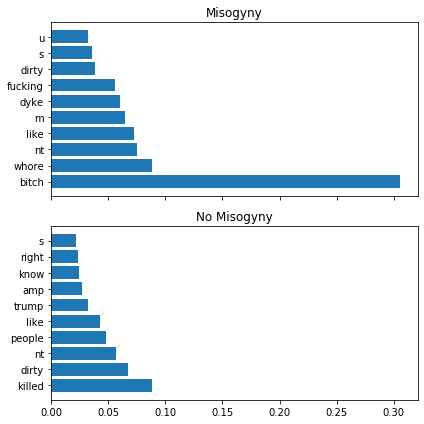

In [108]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
for label, ax in zip(labels, axes):
    ax.set_title(label)
    word_ratio = np.array(most_common[label]['counts']) / most_common[label]['total_number_of_words']
    ax.barh(most_common[label]['top_words'], word_ratio);
plt.tight_layout()

### Wordcloud

In [109]:
from wordcloud import WordCloud

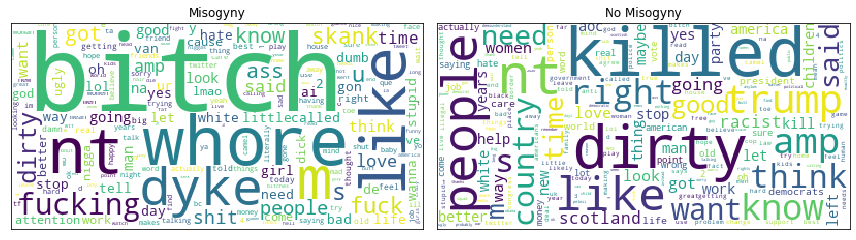

In [118]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 8))
for label, ax, frequencies in zip(labels, axes, counters):
    ax.set_title(label)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    wc = WordCloud(background_color='white').generate_from_frequencies(
        frequencies,
    )
    ax.imshow(wc)
plt.tight_layout()

### Tweets length

Here we compare the length of tweets measured as their total number of characters.
The histograms show a normalized density.

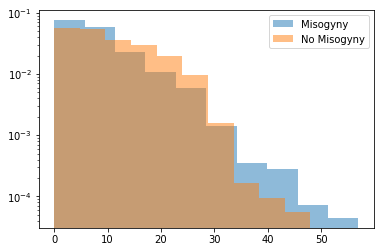

In [113]:
plt.hist(df_msgn['tokens'].apply(len), density=True, alpha=.5, label="Misogyny")
plt.hist(df_non_msgn['tokens'].apply(len), density=True, alpha=.5, label="No Misogyny")
plt.yscale('log')
plt.legend();

It looks like misogynistic tweets tend to use more characters.

### Vectors

In [124]:
docs[0].vector.shape

(300,)

In [42]:
[token for token in docs[0]]

[The, new, Doras, cute, af]

In [119]:
[token.dep_ for token in docs[1]]

['nsubj',
 'ROOT',
 'xcomp',
 'dobj',
 'oprd',
 'cc',
 'conj',
 'punct',
 'nsubj',
 'case',
 'cc',
 'conj',
 'dobj',
 'quantmod',
 'nummod',
 'npadvmod',
 'aux',
 'neg',
 'ROOT',
 'dobj',
 'advmod',
 'punct',
 'ROOT']

In [108]:
t = [token for token in docs[0]][0]

In [109]:
t

these

In [110]:
list(t.ancestors)

[two, are]

In [113]:
t.dep_

'det'

## Old stuff below

In [44]:
%%time
# data['docs'] = create_spacy_docs(data, "text")
data['docs'] = docs

CPU times: user 120 ms, sys: 0 ns, total: 120 ms
Wall time: 118 ms


In [45]:
%%time
misogynistic_docs = data.loc[data.loc[:,'label'] == 1, "docs"]
non_misogynistic_docs = data.loc[data.loc[:,'label'] == 0, "docs"]

CPU times: user 1.13 ms, sys: 7.91 ms, total: 9.04 ms
Wall time: 7.44 ms


In [46]:
%%time
number_of_words_in_misogynistic = sum([len(doc) for doc  in misogynistic_docs])
number_of_words_in_non_misogynistic = sum([len(doc) for doc  in non_misogynistic_docs])

CPU times: user 14.9 ms, sys: 3.83 ms, total: 18.8 ms
Wall time: 17.6 ms


In [47]:
data['docs'].iloc[0]

these two are revolting  2015

In [48]:
%%time
data['stopwords'] = data['text'].apply(remove_stopwords)
data['stopwords_docs'] = create_spacy_docs(data, "stopwords")

CPU times: user 2min 40s, sys: 209 ms, total: 2min 40s
Wall time: 2min 40s


In [49]:
%%time
stop_misogynistic_docs = data.loc[data.loc[:,'label'] == 1, "stopwords_docs"]
stop_non_misogynistic_docs = data.loc[data.loc[:,'label'] == 0, "stopwords_docs"]

number_of_words_in_misogynistic_stop = sum([len(doc) for doc  in stop_misogynistic_docs])
number_of_words_in_non_misogynistic_stop = sum([len(doc) for doc  in stop_non_misogynistic_docs])

misogynistic_common_nouns = pd.DataFrame(find_most_common_nouns(stop_misogynistic_docs), columns=['noun', 'count'])
non_misogynistic_common_nouns = pd.DataFrame(find_most_common_nouns(stop_non_misogynistic_docs), columns=['noun', 'count'])

misogynistic_common_nouns['count'] = misogynistic_common_nouns['count']/number_of_words_in_misogynistic_stop
non_misogynistic_common_nouns['count'] = non_misogynistic_common_nouns['count']/number_of_words_in_non_misogynistic_stop

CPU times: user 7.81 s, sys: 0 ns, total: 7.81 s
Wall time: 7.81 s


In [50]:
misogynistic_common_nouns

,noun,count
0,i,0.016001
1,women,0.004099
2,it,0.002192
3,kat,0.002060
4,girls,0.001819
...,...,...
6302,man circumstances,0.000022
6303,there.(well,0.000022
6304,walk,0.000022
6305,"false ""rape culture"" crisis amp",0.000022


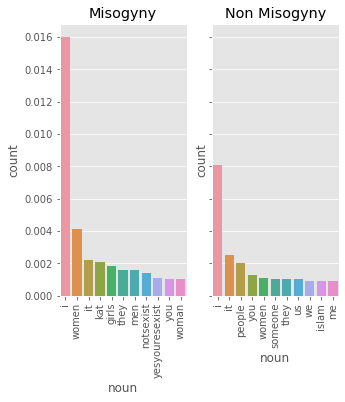

In [51]:
top_10_misogynistic = misogynistic_common_nouns.loc[0:10, :]
top_10_non_misogynistic = non_misogynistic_common_nouns.loc[0:10, :]

fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(5,5))
misogynistic = sns.barplot(x=top_10_misogynistic['noun'], y=top_10_misogynistic['count'], ax=ax[0])
non_misogynistic = sns.barplot(x=top_10_non_misogynistic['noun'], y=top_10_non_misogynistic['count'], ax=ax[1])
ax[0].set_title("Misogyny")
ax[1].set_title("Non Misogyny")

def rotate_ticks(graph1, graph2):
    for item1, item2 in zip(graph1.get_xticklabels(), graph2.get_xticklabels()):
        item1.set_rotation(90)
        item2.set_rotation(90)

rotate_ticks(misogynistic,non_misogynistic)

# plt.savefig(fig_path+"top_10_common_nouns_total_corpus.png")
# plt.show()


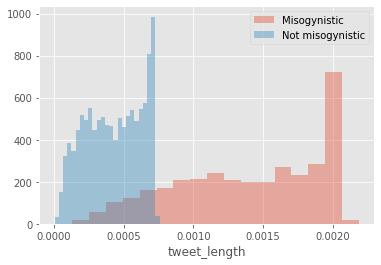

In [54]:
data['tweet_length'] = data["text"].apply(lambda tweet: len(tweet))
data.groupby('label').mean()['tweet_length']

sns.distplot(data.loc[data.loc[:,'label'] == 1, "tweet_length"]/number_of_words_in_misogynistic, kde=False, label="Misogynistic")
sns.distplot(data.loc[data.loc[:,'label'] == 0, "tweet_length"]/number_of_words_in_non_misogynistic, kde=False, label="Not misogynistic")

# plt.savefig(fig_path+"tweet_length_total_corpus.png")

plt.legend();

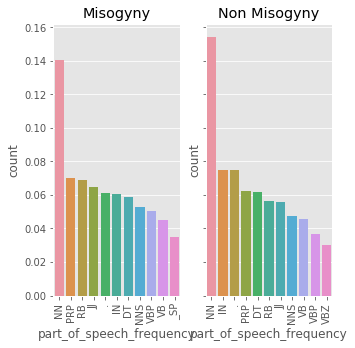

In [94]:
top_10_misogynistic_pos, top_10_non_misogynistic_pos = compare(part_of_speech_frequency, misogynistic_docs, non_misogynistic_docs)
top_10_misogynistic_pos['count'] = top_10_misogynistic_pos['count']/number_of_words_in_misogynistic
top_10_non_misogynistic_pos['count'] = top_10_non_misogynistic_pos['count']/number_of_words_in_non_misogynistic

fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(5,5))
misogynistic = sns.barplot(x=top_10_misogynistic_pos[part_of_speech_frequency.__name__], y=top_10_misogynistic_pos['count'], ax=ax[0])
non_misogynistic = sns.barplot(x=top_10_non_misogynistic_pos[part_of_speech_frequency.__name__], y=top_10_non_misogynistic_pos['count'], ax=ax[1])

ax[0].set_title("Misogyny")
ax[1].set_title("Non Misogyny")

rotate_ticks(misogynistic, non_misogynistic)    
# plt.savefig(fig_path+"pos_frequency_total_corpus.png")
# plt.show()

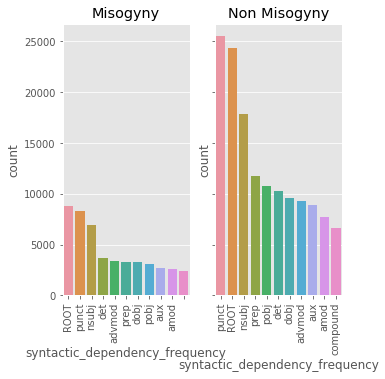

In [130]:
top_10_misogynistic_dep, top_10_non_misogynistic_dep = compare(syntactic_dependency_frequency, misogynistic_docs, non_misogynistic_docs)

fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(5,5))
misogynistic = sns.barplot(x=top_10_misogynistic_dep[syntactic_dependency_frequency.__name__], y=top_10_misogynistic_dep['count'], ax=ax[0])
non_misogynistic = sns.barplot(x=top_10_non_misogynistic_dep[syntactic_dependency_frequency.__name__], y=top_10_non_misogynistic_dep['count'], ax=ax[1])

ax[0].set_title("Misogyny")
ax[1].set_title("Non Misogyny")

rotate_ticks(misogynistic, non_misogynistic)  
# plt.savefig(fig_path+"syntactic_frequency_total_corpus.png")   

# plt.show()

In [136]:
nsubj

429

In [131]:
nsubj_verbs = verb_noun_syntactic_relation(data['docs'], nsubj)  
df_nsubj = pd.DataFrame(nsubj_verbs, columns=["subject", "head_verb"])
print("Verbs Men")
set(df_nsubj[df_nsubj['subject'].str.contains(r"\b(man|men)\b")]['head_verb'].to_list())
print("Verbs Women")
set(df_nsubj[df_nsubj['subject'].str.contains(r"\b(woman|women)\b")]['head_verb'].to_list())

Verbs Men
Verbs Women


/home/guzzo/anaconda3/envs/find-out/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


{'s,
 need,
 speak,
 hide,
 care,
 being,
 been,
 give,
 needed,
 are,
 stay,
 understand,
 are,
 were,
 is,
 give,
 offer,
 are,
 have,
 break,
 was,
 know,
 is,
 rips,
 are,
 are,
 be,
 are,
 feel,
 are,
 write,
 driving,
 gets,
 rap,
 disagree,
 face,
 let,
 ruled,
 have,
 be,
 marries,
 make,
 have,
 be,
 being,
 had,
 do,
 being,
 drive,
 have,
 need,
 died,
 are,
 lack,
 are,
 have,
 said,
 fighting,
 have,
 shame,
 argue,
 joke,
 decide,
 do,
 are,
 have,
 talk,
 seem,
 have,
 tend,
 are,
 wants,
 have,
 paicipate,
 talk,
 have,
 drive,
 have,
 explains,
 call,
 wear,
 get,
 stay,
 take,
 cook,
 familiarise,
 know,
 is,
 having,
 are,
 have,
 living,
 suck,
 be,
 play,
 are,
 control,
 need,
 is,
 see,
 ran,
 do,
 want,
 presents,
 proposing,
 look,
 prefer,
 exist,
 make,
 belong,
 drive,
 talks,
 taking,
 have,
 help,
 are,
 be,
 knowing,
 are,
 are,
 being,
 play,
 driving,
 play,
 fall,
 internalized,
 paicipating,
 did,
 play,
 have,
 assaulted,
 fights,
 drive,
 stand,
 tr

In [122]:
df_nsubj

,subject,head_verb
0,rolling,leaving
1,i,know
2,i,see
3,hostages,were
4,'s,face
...,...,...
23599,you,'re
23600,you,be
23601,i,admit
23602,i,planned


In [127]:
nsubj_verbs, verbs, nouns = verb_noun_word_vectors(data['docs'], nsubj)

In [135]:
nsubj_verbs

{('rolling', leaving),
 ('i', know),
 ('i', see),
 ('hostages', were),
 ("'s", face),
 ('people', need),
 ('you', 're),
 ('who', going),
 ('what', is),
 ('it', 's),
 ('andre', got),
 ('you', 're),
 ('you', cooked),
 ('karma', comes),
 ('who', announces),
 ('mikeofcc', slashing),
 ('night', go),
 ('’m', going),
 ('happiness', oppresses),
 ('it', 's),
 ('i', made),
 ('i', did),
 ('you', are),
 ('i', see),
 ('kat', is),
 ('i', announcing),
 ('i', swear),
 ('you', serving),
 ('it', is),
 ('tribe', steps),
 ('implementation', get),
 ('they', are),
 ('woman', play),
 ('they', are),
 ('i', need),
 ('tip', is),
 ('it', happened),
 ('world', is),
 ('mother', hoped),
 ('they', scored),
 ('it', 's),
 ('.', done),
 ('i', adore),
 ('vivek', got),
 ('it', go),
 ('algebra', came),
 ('i', thought),
 ('it', explain),
 ('i', hope),
 ('they', lace),
 ('that', provides),
 ('we', took),
 ('they', play),
 ('i', have),
 ('it', 's),
 ('that', 's),
 ('i', was),
 ('palestinians', defend),
 ('they', existed),
 (

In [128]:
nouns

chararray([['two'],
           ["you're"],
           ['i'],
           ...,
           [''],
           ["'s"],
           ['']], dtype='<U50')

Text(0.5, 1.0, 'Female Verbs')

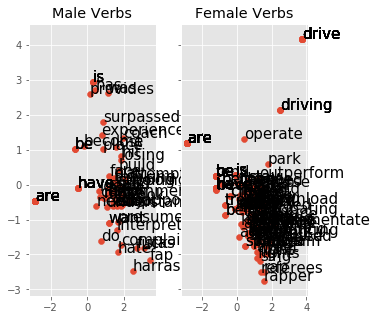

In [129]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(5,5))
male_verb_index = [n for n, j in enumerate(nouns) if j[0] == "man" or  j[0] == "men" ]
ax[0] = plot_word_vectors(nsubj_verbs[male_verb_index, :], verbs[male_verb_index, :], ax[0])
ax[0].set_title("Male Verbs")

female_verb_index = [n for n, j in enumerate(nouns) if j[0] == "woman" or  j[0] == "women" ]
ax[1] = plot_word_vectors(nsubj_verbs[female_verb_index, :], verbs[female_verb_index, :], ax[1])
ax[1].set_title("Female Verbs")
# plt.savefig(fig_path+"word_vectors_total_corpus.png")   

# plt.show()

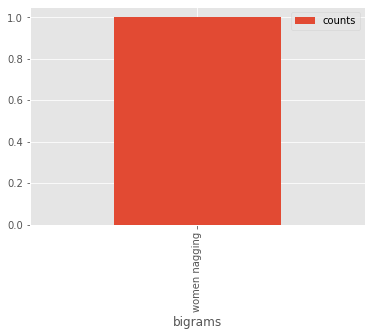

In [126]:
bigrams = data['text'].apply(lambda tweet: generate_ngrams(tweet, 2))
df_bigrams = pd.DataFrame(bigram for bigram in bigrams)
df_bigrams = df_bigrams.fillna("no bigram")

ADJECTIVE = ["battered", "untreated", "barren", "shrewish", "sheltered", "heartbroken", "unmarried", "undernourished", "underweight", "uncomplaining", "nagging"]
FEMALE = ["women", "woman"]

all_bigrams = []
for i in range(0, len(df_bigrams.columns)):
    all_bigrams.append(df_bigrams[i].apply(lambda bigram: contains_bigram(bigram, ADJECTIVE, FEMALE)))

counts = count_pejorative_bigrams(all_bigrams)
df_bigrams_counts = pd.DataFrame(counts, columns=["bigrams", "counts"]).groupby("bigrams").count().plot.bar()
# plt.show()